# ARIMA(X) Models with GARCH

### Import Libraries and Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from ta import add_all_ta_features
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

### Import Data

In [2]:
path = ""
intraday_data = pd.read_csv(path+'SPY_1min_firstratedata.csv', parse_dates=['timestamp'], index_col='timestamp')

### Add Features

In [ ]:
# Add technical indicators using the 'ta' library
intraday_data = add_all_ta_features(intraday_data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

# Time left until Close within each day
intraday_data['Time_Left'] = intraday_data.groupby(intraday_data.index.date).cumcount(ascending=False)

# Simple Moving Averages
intraday_data['sma_5'] = intraday_data['close'].rolling(window=5).mean()  # Simple Moving Average
intraday_data['sma_30'] = intraday_data['close'].rolling(window=30).mean()
intraday_data['sma_100'] = intraday_data['close'].rolling(window=30).mean()
intraday_data['sma_200'] = intraday_data['close'].rolling(window=200).mean()

### Calculate Intraday Returns, Truncate Dataset to Open Market Hours

In [4]:

# Filter data to include only market hours
market_open_time = '09:30:00'
market_close_time = '16:00:00'
intraday_data = intraday_data[(intraday_data.index.time >= pd.to_datetime(market_open_time).time()) &
                              (intraday_data.index.time <= pd.to_datetime(market_close_time).time())]

# Calculate the daily returns based on the first close of the day
intraday_data['first_close'] = intraday_data.groupby(intraday_data.index.date)['close'].transform('first')
intraday_data['last_close'] = intraday_data.groupby(intraday_data.index.date)['close'].transform('last')
intraday_data['intraday_return'] = (intraday_data['close'] / intraday_data['first_close']) - 1
intraday_data['Ima_5'] = intraday_data['intraday_return'].rolling(window=5).mean()  
intraday_data['Ima_30'] = intraday_data['intraday_return'].rolling(window=30).mean()
intraday_data['Ima_100'] = intraday_data['intraday_return'].rolling(window=100).mean()

## Stationarity Testing and ARIMA Parameters Selection

ADF Statistic: -14.74325409902915
p-value: 2.5513044512247626e-27


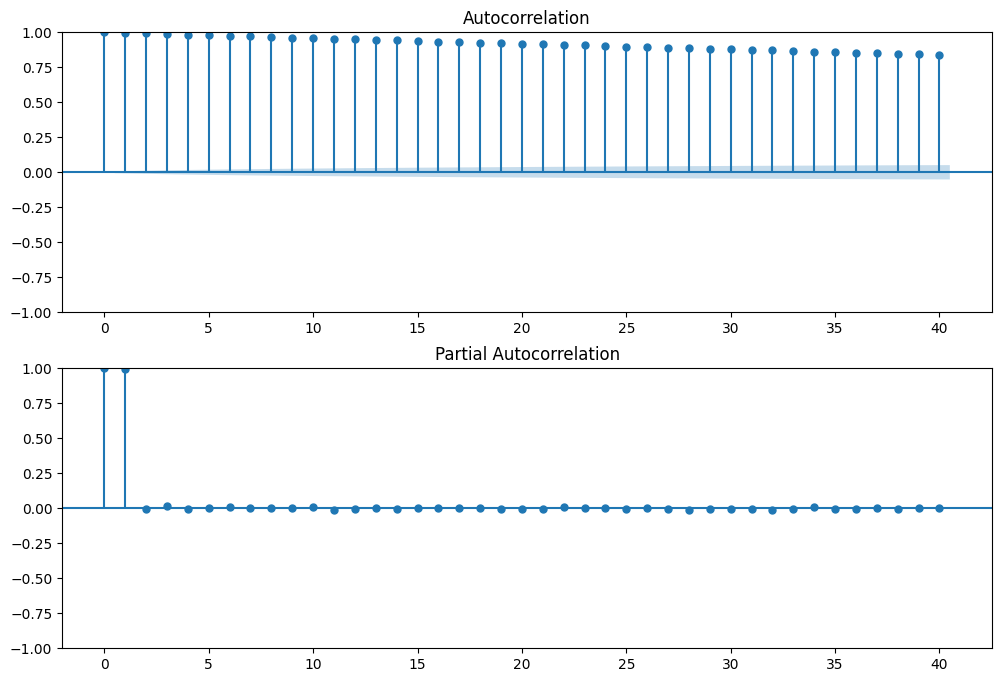

In [28]:
# Check for stationarity of the 'intraday_return' column
result = adfuller(intraday_data['intraday_return'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value > 0.05, we consider the series to be non-stationary and difference it
# Since your series is already stationary, we can skip differencing

# Determine the ARIMA(p,d,q) parameters using ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
sm.graphics.tsa.plot_acf(intraday_data['intraday_return'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(intraday_data['intraday_return'], lags=40, ax=ax2)
plt.show()

# From these plots, determine the values of p and q (d is 0 as the series is stationary)
# For example, if the PACF cuts off after the first lag, p=1
# If the ACF tails off, you can start with q=1


## Fit ARIMA Model, Plot Results

### ARIMA(1,0,0)

/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

                               SARIMAX Results                                
Dep. Variable:        intraday_return   No. Observations:                97994
Model:                 ARIMA(1, 0, 0)   Log Likelihood              584909.864
Date:                Thu, 28 Dec 2023   AIC                       -1169813.729
Time:                        11:07:36   BIC                       -1169785.251
Sample:                             0   HQIC                      -1169805.078
                              - 97994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.644      0.520      -0.001       0.001
ar.L1          0.9957      0.000   3306.918      0.000       0.995       0.996
sigma2      3.829e-07   2.48e-10   1546.520      0.0

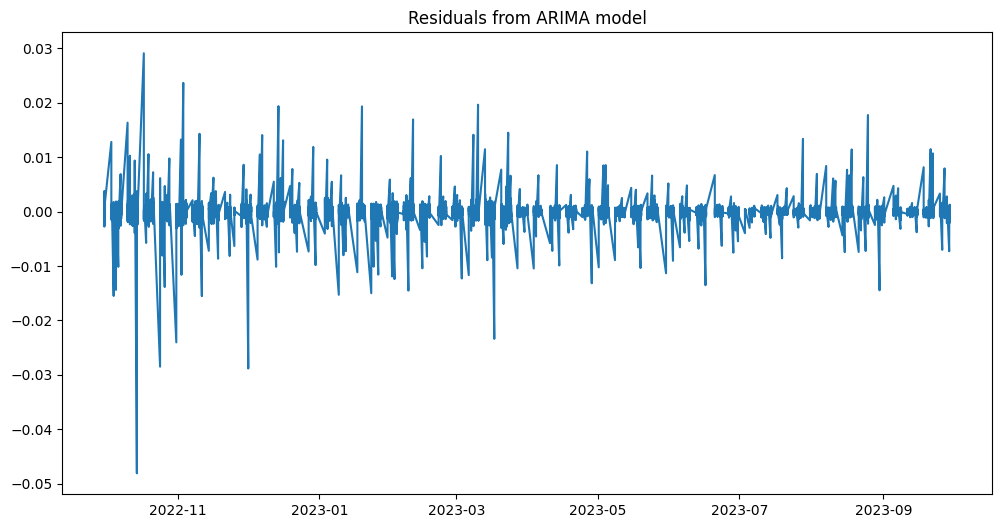

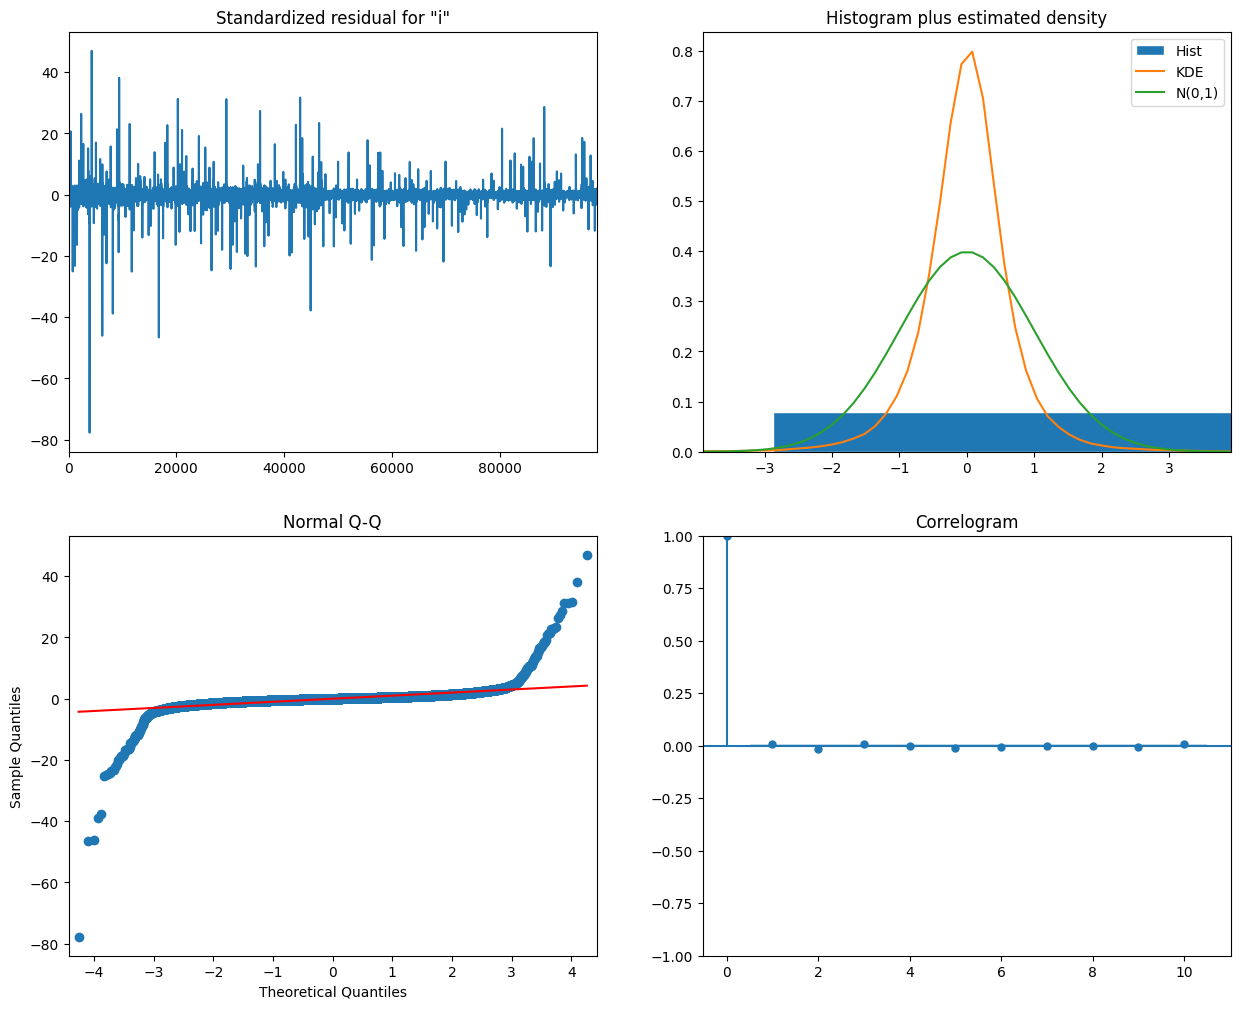

/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


intraday_return,mean,mean_se,mean_ci_lower,mean_ci_upper
97994,-0.009050,0.000619,-0.010263,-0.007838
97995,-0.009010,0.000873,-0.010721,-0.007299
97996,-0.008970,0.001067,-0.011061,-0.006878
97997,-0.008930,0.001230,-0.011340,-0.006520
97998,-0.008890,0.001372,-0.011579,-0.006201
97999,-0.008850,0.001499,-0.011789,-0.005912
98000,-0.008811,0.001616,-0.011978,-0.005643
98001,-0.008772,0.001724,-0.012151,-0.005393
98002,-0.008732,0.001825,-0.012309,-0.005156
98003,-0.008693,0.001919,-0.012455,-0.004932


In [29]:
# Fit the ARIMA model
# Replace p, d, q with the parameters you've determined
model = ARIMA(intraday_data['intraday_return'], order=(1,0,0))
results = model.fit()

# Summarize the model
print(results.summary())

# Check for model residuals
residuals = results.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Residuals from ARIMA model')
plt.show()

# Perform diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting future values
# Set 'steps' to the number of periods you want to forecast
forecast = results.get_forecast(steps=10)
forecast.summary_frame(alpha=0.05)  # 95% conf

### ARIMA(1,0,1)

In [ ]:
# Fit the ARIMA model
# Replace p, d, q with the parameters you've determined
model = ARIMA(intraday_data['intraday_return'], order=(1,0,1))
results = model.fit()

# Summarize the model
print(results.summary())

# Check for model residuals
residuals = results.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Residuals from ARIMA model')
plt.show()

# Perform diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting future values
# Set 'steps' to the number of periods you want to forecast
forecast = results.get_forecast(steps=10)
forecast.summary_frame(alpha=0.05)  # 95% conf

In [26]:
std = intraday_data['intraday_return'].std()
mean =intraday_data['intraday_return'].mean()
print(f'Intraday Return Mean: {mean}')
print(f'Intraday Return Standard Deviation: {std}')

Intraday Return Mean: 0.00030172747912895326
Intraday Return Standard Deviation: 0.006660663918742894


## ARIMA(1,0,1) Forecasting for 1 Day Scope, with Confidence Band

/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

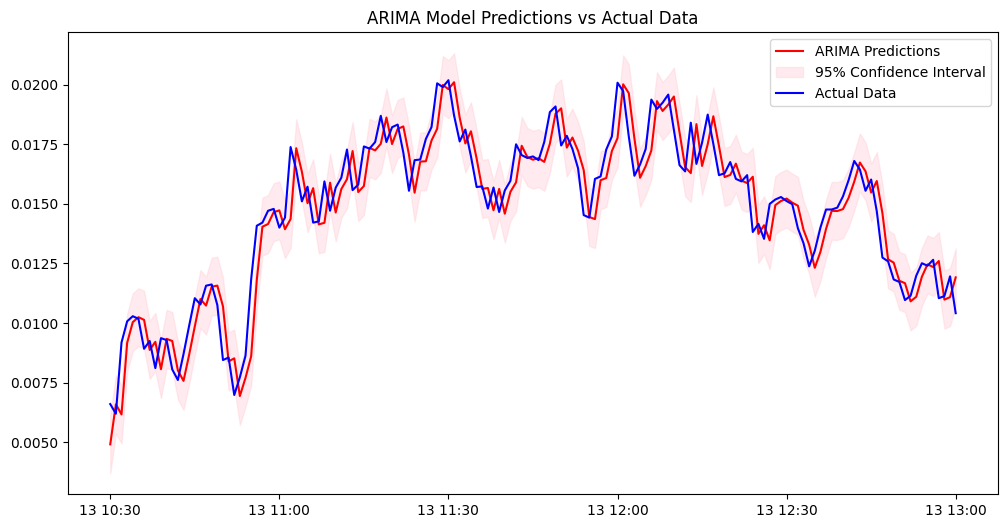

In [24]:
# Fit the ARIMA model (assuming you have already determined the order (p,d,q) you want to use)
model = ARIMA(intraday_data['intraday_return'], order=(1,0,1))
results = model.fit()

# Given time period to forecast
forecast_start = '2023-03-13 10:30:00'
forecast_end = '2023-03-13 13:00:00'

# Get the predictions from the model for the specified time window
predictions = results.get_prediction(start=forecast_start, end=forecast_end)
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

# Retrieve the actual data for the same time window
actual = intraday_data[forecast_start:forecast_end]['intraday_return']

# Plot the predictions against the actual data
plt.figure(figsize=(12, 6))
plt.plot(predicted_mean.index, predicted_mean, label='ARIMA Predictions', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.plot(actual.index, actual, label='Actual Data', color='blue')
plt.legend()
plt.title('ARIMA Model Predictions vs Actual Data')
plt.show()


## Fit ARIMAX Model (Include other Features, Standardized)

In [58]:
# Shift exogenous variables by one time step
exog_vars_shifted = intraday_data[['open', 'high', 'low', 'close', 'volume', 'momentum_rsi', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff']].shift(1)

# Drop the first row of shifted exogenous variables and target variable to align them
exog_vars_shifted = exog_vars_shifted.dropna()
target_var_shifted = intraday_data['intraday_return'].iloc[1:]

# Fit the scaler for exogenous variables
exog_scaler = StandardScaler()
exog_vars_scaled = exog_scaler.fit_transform(exog_vars_shifted)

# Fit a separate scaler for the target variable
target_scaler = StandardScaler()
target_scaled = target_scaler.fit_transform(target_var_shifted.values.reshape(-1, 1))

# Fit ARIMAX Model
model = sm.tsa.statespace.SARIMAX(target_scaled.flatten(),
                                  order=(1, 0, 1),
                                  exog=exog_vars_scaled,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

# Increase the iteration limit here
results = model.fit(maxiter=400)  

# Print results
print(results.summary())

residuals = results.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Residuals from ARIMAX model')
plt.show()

results.plot_diagnostics(figsize=(15, 12))
plt.show()



KeyboardInterrupt



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                97994
Model:               SARIMAX(1, 0, 1)   Log Likelihood              123766.517
Date:                Thu, 28 Dec 2023   AIC                        -247509.033
Time:                        12:30:15   BIC                        -247395.122
Sample:                             0   HQIC                       -247474.432
                              - 97994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.4907      0.022   -115.067      0.000      -2.533      -2.448
x2            -0.4635      0.018    -25.536      0.000      -0.499      -0.428
x3            -0.1020      0.021     -4.787      0.0

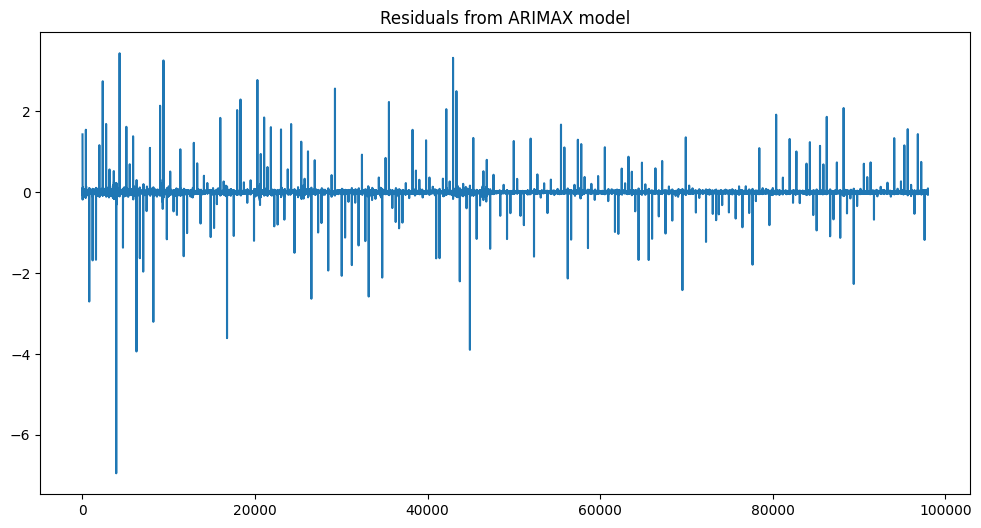

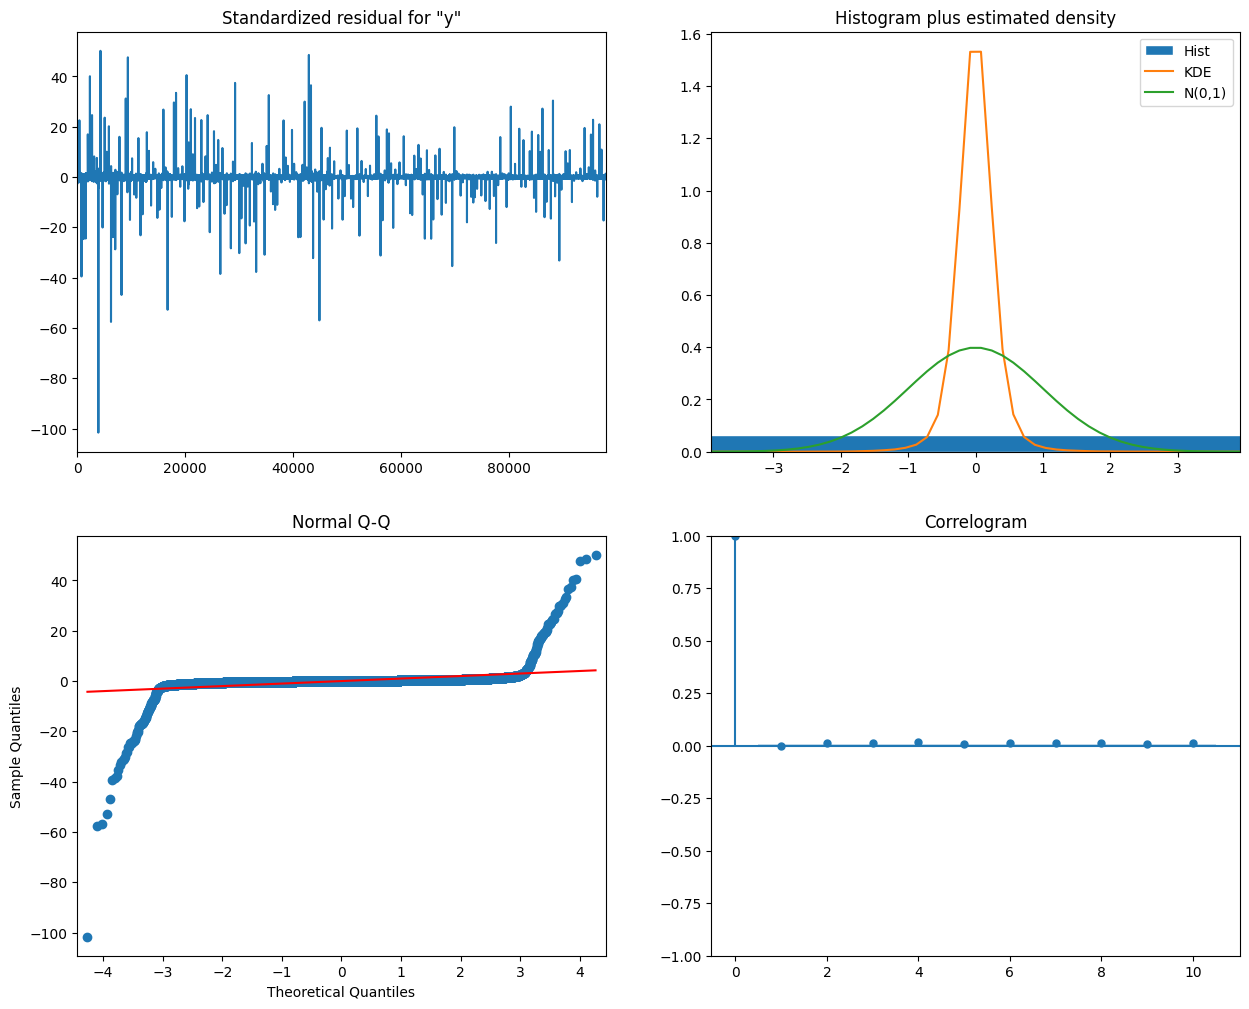

## ARIMAX Forecasting for 1 Day Scope, with Confidence Band

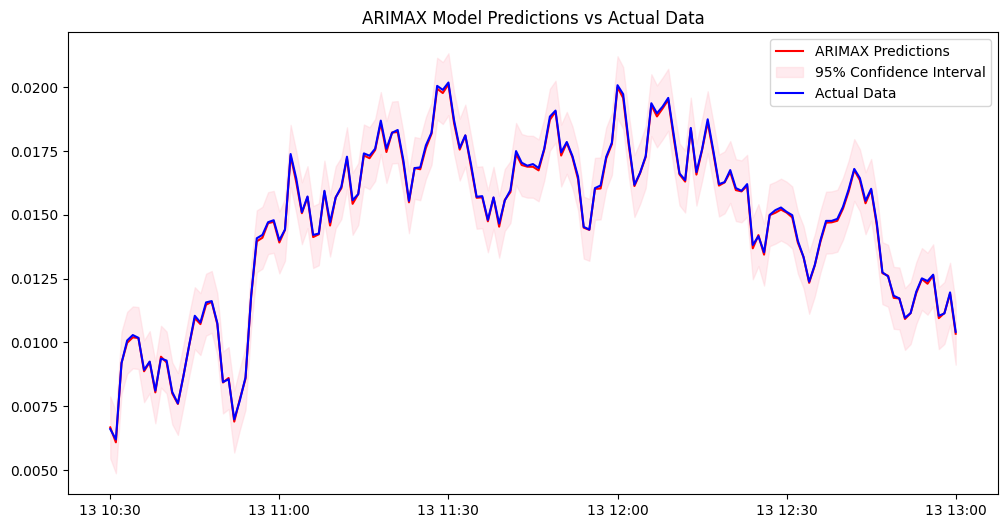

In [57]:
# Given time period to forecast
forecast_start = '2023-03-13 10:30:00'
forecast_end = '2023-03-13 13:00:00'

# Convert the forecast start and end times to datetime objects
forecast_start_dt = pd.to_datetime(forecast_start)
forecast_end_dt = pd.to_datetime(forecast_end)

# Find the integer locations corresponding to these times
start_loc = intraday_data.index.get_loc(forecast_start_dt)
end_loc = intraday_data.index.get_loc(forecast_end_dt)

# Get exogenous variables for the forecast period
exog_forecast = exog_scaler.transform(intraday_data.loc[forecast_start:forecast_end, exog_vars.columns])

# Get the predictions from the model for the specified time window
predictions = results.get_prediction(start=start_loc, end=end_loc, exog=exog_forecast)
predicted_mean = predictions.predicted_mean

# Inverse transform to original scale
predicted_mean_scaled = target_scaler.inverse_transform(predicted_mean.reshape(-1, 1))

# Get confidence intervals and inverse transform to original scale
conf_int_scaled = target_scaler.inverse_transform(predictions.conf_int())
conf_int_lower = conf_int_scaled[:, 0]
conf_int_upper = conf_int_scaled[:, 1]

# Retrieve the actual data for the same time window
actual = intraday_data.iloc[start_loc:end_loc+1, intraday_data.columns.get_loc('intraday_return')]

# Plot the predictions against the actual data
plt.figure(figsize=(12, 6))
plt.plot(intraday_data.index[start_loc:end_loc+1], predicted_mean_scaled.flatten(), label='ARIMAX Predictions', color='red')
plt.fill_between(intraday_data.index[start_loc:end_loc+1], conf_int_lower, conf_int_upper, color='pink', alpha=0.3, label='95% Confidence Interval')
plt.plot(intraday_data.index[start_loc:end_loc+1], actual, label='Actual Data', color='blue')
plt.legend()
plt.title('ARIMAX Model Predictions vs Actual Data')
plt.show()

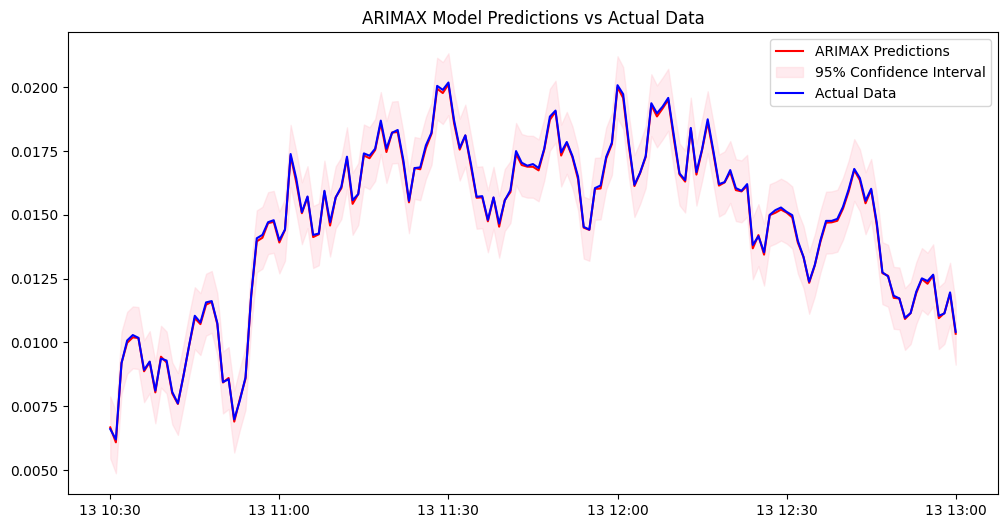

In [67]:
# Given time period to forecast
forecast_start = '2023-03-13 10:30:00'
forecast_end = '2023-03-13 13:00:00'

# Convert the forecast start and end times to datetime objects
forecast_start_dt = pd.to_datetime(forecast_start)
forecast_end_dt = pd.to_datetime(forecast_end)

# Find the integer locations corresponding to these times
start_loc = intraday_data.index.get_loc(forecast_start_dt)
end_loc = intraday_data.index.get_loc(forecast_end_dt)

# Get exogenous variables for the forecast period
exog_forecast = exog_scaler.transform(intraday_data.loc[forecast_start:forecast_end, exog_vars.columns])

# Get the predictions from the model for the specified time window
predictions = results.get_prediction(start=start_loc, end=end_loc, exog=exog_forecast)
predicted_mean = predictions.predicted_mean

# Inverse transform to original scale
predicted_mean_scaled = target_scaler.inverse_transform(predicted_mean.reshape(-1, 1))

# Get confidence intervals and inverse transform to original scale
conf_int_scaled = target_scaler.inverse_transform(predictions.conf_int())
conf_int_lower = conf_int_scaled[:, 0]
conf_int_upper = conf_int_scaled[:, 1]

# Retrieve the actual data for the corresponding time window of the predictions
actual = intraday_data.iloc[start_loc:end_loc+1, intraday_data.columns.get_loc('intraday_return')]

# Plot the predictions against the actual data
plt.figure(figsize=(12, 6))
# Use the actual data's index for plotting
plt.plot(actual.index, predicted_mean_scaled.flatten(), label='ARIMAX Predictions', color='red')
plt.fill_between(actual.index, conf_int_lower, conf_int_upper, color='pink', alpha=0.3, label='95% Confidence Interval')
plt.plot(actual.index, actual, label='Actual Data', color='blue')
plt.legend()
plt.title('ARIMAX Model Predictions vs Actual Data')
plt.show()

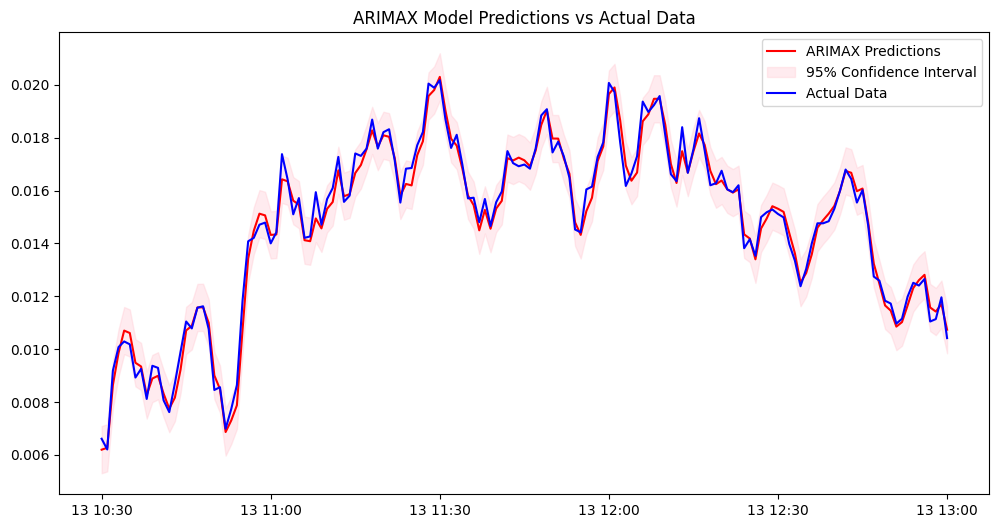

In [54]:
# Given time period to forecast
forecast_start = '2023-03-13 10:30:00'
forecast_end = '2023-03-13 13:00:00'

# Convert the forecast start and end times to datetime objects
forecast_start_dt = pd.to_datetime(forecast_start)
forecast_end_dt = pd.to_datetime(forecast_end)

# Find the integer locations corresponding to these times
start_loc = intraday_data.index.get_loc(forecast_start_dt)
end_loc = intraday_data.index.get_loc(forecast_end_dt)

# Get exogenous variables for the forecast period
exog_forecast = exog_scaler.transform(intraday_data.loc[forecast_start:forecast_end, exog_vars.columns])

# Get the predictions from the model for the specified time window
predictions = results.get_prediction(start=start_loc, end=end_loc, exog=exog_forecast)
predicted_mean = predictions.predicted_mean

# Inverse transform to original scale
predicted_mean_scaled = target_scaler.inverse_transform(predicted_mean.reshape(-1, 1))

# Get confidence intervals and inverse transform to original scale
conf_int_scaled = target_scaler.inverse_transform(predictions.conf_int())
conf_int_lower = conf_int_scaled[:, 0]
conf_int_upper = conf_int_scaled[:, 1]

# Retrieve the actual data for the same time window
actual = intraday_data.iloc[start_loc:end_loc+1, intraday_data.columns.get_loc('intraday_return')]

# Plot the predictions against the actual data
plt.figure(figsize=(12, 6))
plt.plot(intraday_data.index[start_loc:end_loc+1], predicted_mean_scaled.flatten(), label='ARIMAX Predictions', color='red')
plt.fill_between(intraday_data.index[start_loc:end_loc+1], conf_int_lower, conf_int_upper, color='pink', alpha=0.3, label='95% Confidence Interval')
plt.plot(intraday_data.index[start_loc:end_loc+1], actual, label='Actual Data', color='blue')
plt.legend()
plt.title('ARIMAX Model Predictions vs Actual Data')
plt.show()

### t-SNE for Dimensionality Reduction

In [ ]:
# intraday_data DataFrame with multiple features
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(intraday_data)

plt.figure(figsize=(12,8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE visualization')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

## Implement GARCH to Address Heteroskedasticity, ARIMAX Residuals

In [68]:
from arch import arch_model

residuals = results.resid

garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_results = garch_model.fit(update_freq=10)
print(garch_results.summary())

/Users/briankregel/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008621. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Optimization terminated successfully    (Exit mode 0)
            Current function value: -105894.05887726486
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                105894.
Distribution:                  Normal   AIC:                          -211780.
Method:            Maximum Likelihood   BIC:                          -211742.
                                        No. Observations:                97993
Date:                Fri, Dec 29 2023   Df Residuals:                    97992
Time:                        01:23:18   Df Model:                            1
                                  Mean Model                                  
 

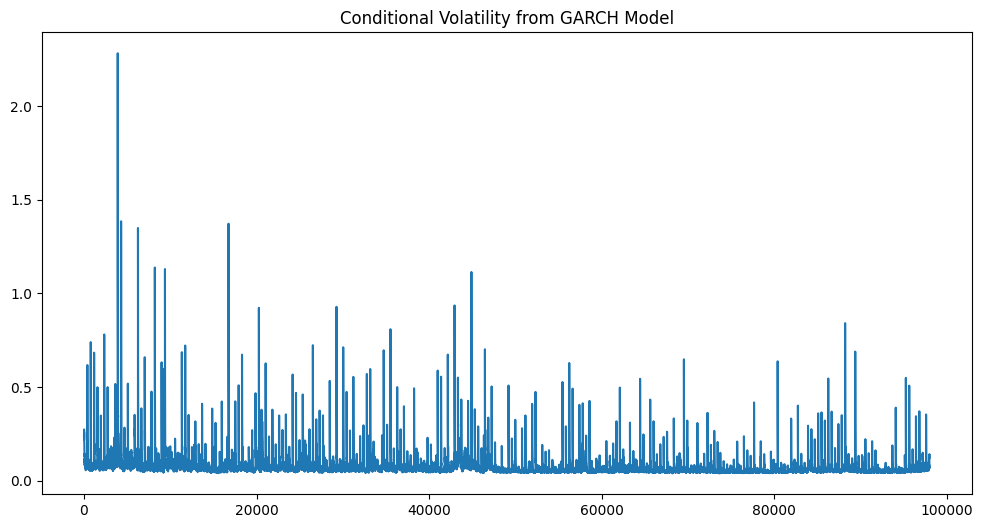

In [69]:
plt.figure(figsize=(12,6))
plt.plot(garch_results.conditional_volatility)
plt.title('Conditional Volatility from GARCH Model')
plt.show()

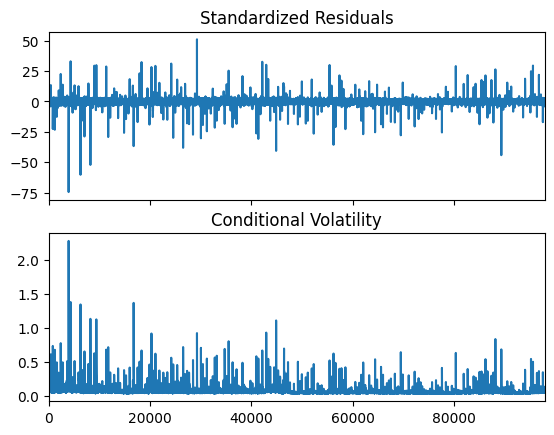

In [70]:
garch_results.plot()
plt.show()